# Fake reviwe Detection

1. Dataset

we have the original review datset from on a publicly available source now we will use T5 Model to generate the fake review and shuffle oth the datasets and store them as a csv file

In [ ]:
import pandas as pd
import numpy as np
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch
from tqdm import tqdm
import random

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

def load_t5_model():
    """Load T5 model with error handling"""
    try:
        # Use smaller model for faster execution
        model_name = 't5-small'
        tokenizer = T5Tokenizer.from_pretrained(model_name)
        model = T5ForConditionalGeneration.from_pretrained(model_name)

        # Move to GPU if available
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)

        return model, tokenizer, device
    except Exception as e:
        print(f"Error loading model: {e}")
        raise

# Load dataset
try:
    original_df = pd.read_csv('test.csv')
    original_df['label'] = 'OG'  # Original reviews
except FileNotFoundError:
    print("Error: 'test.csv' not found in current directory")
    raise

# Initialize T5 model
try:
    model, tokenizer, device = load_t5_model()
except:
    print("Failed to initialize T5 model")
    raise

def generate_t5_review(product_id, original_df, max_length=80):
    """Generate a fake review using T5 model with error handling"""
    try:
        # Get product context
        product_reviews = original_df[original_df['item_id'] == product_id]['review']
        example_review = product_reviews.sample(1).iloc[0] if len(product_reviews) > 0 else "a product"

        input_text = f"generate a fake product review similar to: {example_review[:200]}"  # Limit context length

        inputs = tokenizer.encode(input_text, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model.generate(
                inputs,
                max_length=max_length,
                do_sample=True,
                temperature=0.9,  # Higher temperature for more creativity
                top_k=50,
                top_p=0.95,
                num_return_sequences=1
            )

        review = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Post-processing
        review = review.split('.')[0] + '.'
        review = review.replace('"', '').strip()

        return review if len(review) > 10 else "Excellent product, works perfectly."

    except Exception as e:
        print(f"Error generating review for product {product_id}: {e}")
        return "Great product, highly recommended."

# Generate fake reviews
fake_reviews = []
unique_products = original_df['item_id'].unique()

try:
    for i, product_id in enumerate(tqdm(unique_products[:len(original_df)], desc="Generating reviews")):
        review_text = generate_t5_review(product_id, original_df)

        fake_reviews.append({
            'qid': len(original_df) + i + 1,
            'item_id': product_id,
            'user_id': f"T5USER{i+1:04d}",
            'rating': min(5, max(1, int(np.random.normal(4.2, 0.8)))),
            'review': review_text,
            'label': 'CG'  # Computer Generated
        })
except Exception as e:
    print(f"Error during review generation: {e}")

# Create DataFrame and combine
if fake_reviews:
    fake_df = pd.DataFrame(fake_reviews)
    combined_df = pd.concat([original_df, fake_df])

    # Shuffle the dataset
    combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Save to CSV
    combined_df.to_csv('t5_generated_reviews.csv', index=False)
    print(f"Successfully generated dataset with {len(original_df)} real and {len(fake_df)} fake reviews")
else:
    print("Failed to generate any fake reviews")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Generating reviews: 100%|██████████| 20463/20463 [7:14:40<00:00,  1.27s/it]


Successfully generated dataset with 21223 real and 20463 fake reviews


In [ ]:
!pip install pandas numpy torch transformers tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
!pip install torch --extra-index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117


In [ ]:
!pip install torch==2.0.1 transformers==4.30.2 pandas numpy tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 833.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

2. Load the requied modules

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re

3. Data Preprocessing
now we will load the data and perform the EDA

In [ ]:
data = pd.read_csv("/content/t5_generated_reviews.csv")

In [ ]:
data.head(10)

,qid,item_id,user_id,rating,review,label
0,23267,B0BNB1XTYY,T5USER2044,4,"Excellent product, works perfectly.",CG
1,15031,B09FSFGM8C,AGI3P42W4XXWUVZDY6AAAUBT7COA,5,heart warming It was nice to see that a man ca...,OG
2,12430,B0B59QBY9G,AEHC7E4QIJN72QKBVSMW3QOTT4JA,5,OMG I love these I got these for my computer a...,OG
3,39805,B09LV2WPF6,T5USER18582,3,", looks perfect All parts fit and directions w...",CG
4,12880,B0B822YLNY,AHMLRDLKVDAJ3EBXQUROJWHMSTGQ,5,Perfect Socks! I love these socks! They are so...,OG
5,35569,B09R8FMYL3,T5USER14346,5,"Excellent product, works perfectly.",CG
6,19407,B00KJLMGYI,AF4D4V6HS6ANZJSJ3KKFSLZCVG4Q,5,"Great quality, easy to install. I just install...",OG
7,3000,B0BWYDZF2Z,AG5XOHWUMFBAO3L72WA6HNDPGDWQ,5,Love these! These work great with Alexa! I lov...,OG
8,34958,B084QDJZSF,T5USER13735,5,Watergate then watch Slow Burn.,CG
9,30067,B01MTQW73F,T5USER8844,5,: Great lawnmower! This grassmower mowed every...,CG


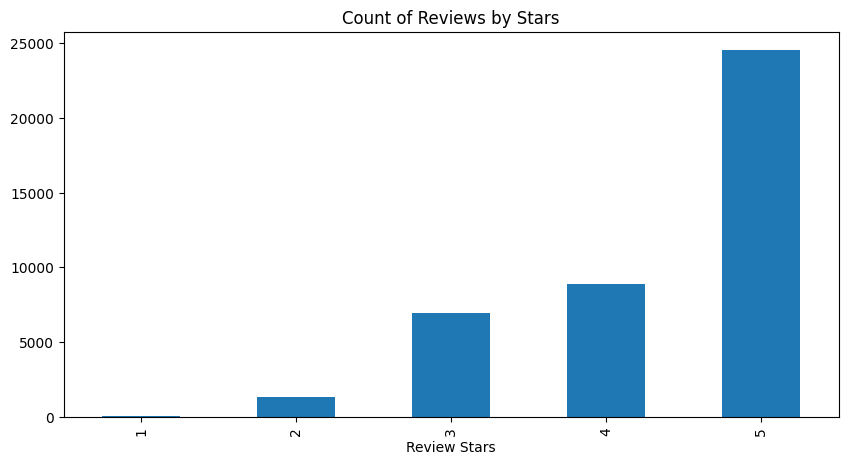

In [ ]:
ax = data['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

In [ ]:
data.shape

(41686, 6)

In [ ]:
print(data.info())
print(data.describe())
print(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41686 entries, 0 to 41685
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   qid      41686 non-null  int64 
 1   item_id  41686 non-null  object
 2   user_id  41686 non-null  object
 3   rating   41686 non-null  int64 
 4   review   41686 non-null  object
 5   label    41686 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB
None
                qid        rating
count  41686.000000  41686.000000
mean   20842.990884      4.354867
std    12034.288874      0.876676
min        0.000000      1.000000
25%    10421.250000      4.000000
50%    20842.500000      5.000000
75%    31264.750000      5.000000
max    41686.000000      5.000000
qid        0
item_id    0
user_id    0
rating     0
review     0
label      0
dtype: int64


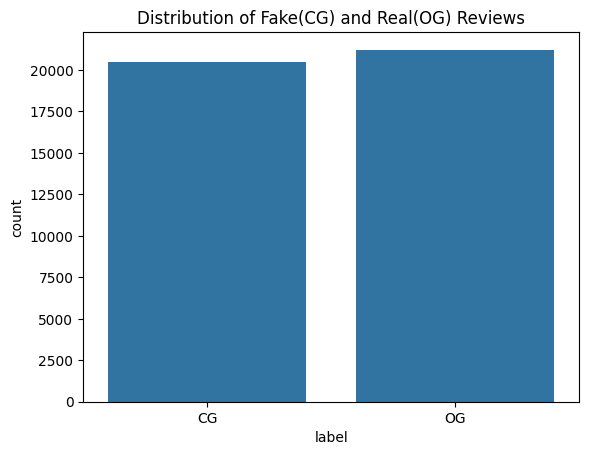

label
OG    0.509116
CG    0.490884
Name: proportion, dtype: float64


In [ ]:
sns.countplot(x='label', data=data)
plt.title('Distribution of Fake(CG) and Real(OG) Reviews')
plt.show()

print(data['label'].value_counts(normalize=True))


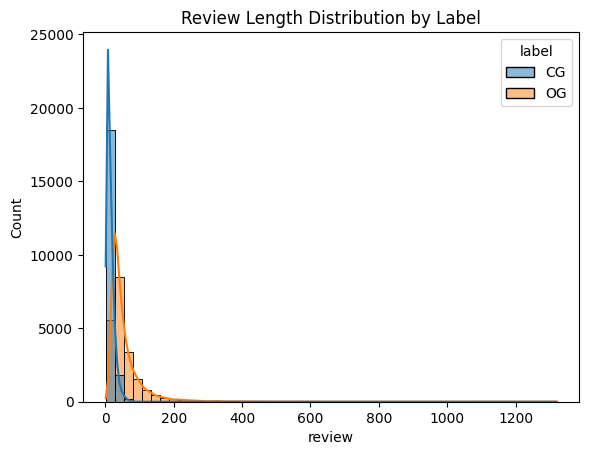

In [ ]:

sns.histplot(data=data, x=data['review'].apply(lambda x: len(str(x).split())), hue='label', bins=50, kde=True)
plt.title('Review Length Distribution by Label')

plt.show()


All the feature in our dataset are very important for making business decisions but for this project we need only specific feature do we will drop the other un necessary ones

In [ ]:
#droping the unwanted features
df = data.drop(columns=['item_id','qid', 'user_id', 'review_length', 'rating'], errors='ignore')
df.head()

,review,label
0,"Excellent product, works perfectly.",CG
1,heart warming It was nice to see that a man ca...,OG
2,OMG I love these I got these for my computer a...,OG
3,", looks perfect All parts fit and directions w...",CG
4,Perfect Socks! I love these socks! They are so...,OG


In [ ]:
import nltk
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
import string
stopword=set(stopwords.words('english'))

def text_cleaning(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df['review'] = df["review"].apply(text_cleaning)

In [ ]:
df.head(20)

,review,label
0,excel product work perfect,CG
1,heart warm nice see man love child isn't blood...,OG
2,omg love got comput work sit inconspicu monit...,OG
3,look perfect part fit direct clear,CG
4,perfect sock love sock soft warm cozi tight ni...,OG
5,excel product work perfect,CG
6,great qualiti easi instal instal tuff support ...,OG
7,love work great alexa love dim featur definit ...,OG
8,waterg watch slow burn,CG
9,great lawnmow grassmow mow everi bit,CG


In [ ]:
new_data = df.head(41686)
new_data = new_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:

new_data.to_csv("cleandata.csv", index=False)


In [ ]:
cleandata = pd.read_csv("cleandata.csv")
cleandata.shape

(41686, 2)

In [ ]:
cleandata['id'] = range(1, len(cleandata) + 1)
cleandata.head(10)

,review,label,id
0,long sleev scrub shirt love,CG,1
1,fit everyth,CG,2
2,great set strong magnet super strong use mount...,OG,3
3,love wipe order set love work great diaper wi...,OG,4
4,laredo tien una salida de pulgada de ancho en...,CG,5
5,excel product work perfect,CG,6
6,posit respons recommend cook illustr best peel...,CG,7
7,look durabl great gift hubbi alway joke “no r...,OG,8
8,gorilla glue strong reliabl gorilla glue,CG,9
9,love oh love book spooki dark mysteri everyth ...,OG,10


In [ ]:
print(cleandata.isnull().sum())

review    34
label      0
id         0
dtype: int64


In [ ]:
cleandata.dropna(inplace=True)


In [ ]:
print(cleandata.isnull().sum())


review    0
label     0
id        0
dtype: int64


In [ ]:
cleandata.head(10)

,review,label,id
0,long sleev scrub shirt love,CG,1
1,fit everyth,CG,2
2,great set strong magnet super strong use mount...,OG,3
3,love wipe order set love work great diaper wi...,OG,4
4,laredo tien una salida de pulgada de ancho en...,CG,5
5,excel product work perfect,CG,6
6,posit respons recommend cook illustr best peel...,CG,7
7,look durabl great gift hubbi alway joke “no r...,OG,8
8,gorilla glue strong reliabl gorilla glue,CG,9
9,love oh love book spooki dark mysteri everyth ...,OG,10


# **Spliting the data**

In [ ]:
x = cleandata["review"]
y = cleandata["label"]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorization = TfidfVectorizer()
xv_train_np = vectorization.fit_transform(x_train)
xv_test_np = vectorization.transform(x_test)


# **Building the Models**

**1. Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
LR = LogisticRegression()
#LR.fit(xv_train, y_train)
LR.fit(xv_train_np, y_train)

LogisticRegression()

In [ ]:
#LR.score(xv_test, y_test)
LR.score(xv_test_np, y_test)

0.8721991037131882

In [ ]:
#pred_LR = LR.predict(xv_test)
pred_LR = LR.predict(xv_test_np)

In [ ]:
print(classification_report(y_test, pred_LR))

              precision    recall  f1-score   support

          CG       0.90      0.84      0.87      6159
          OG       0.85      0.91      0.88      6337

    accuracy                           0.87     12496
   macro avg       0.87      0.87      0.87     12496
weighted avg       0.87      0.87      0.87     12496



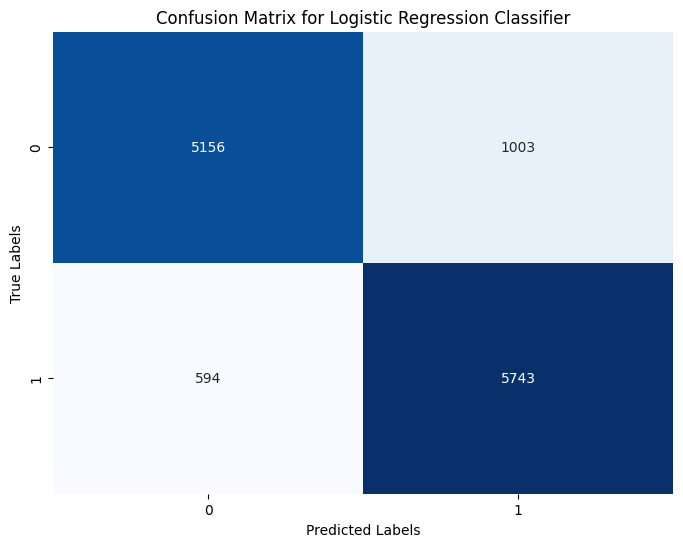

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Calculate the confusion matrix
cm = confusion_matrix(y_test, pred_LR)

#Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Logistic Regression Classifier")
plt.show()

**2. Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
DT = DecisionTreeClassifier()
#DT.fit(xv_train, y_train)
DT.fit(xv_train_np, y_train)

DecisionTreeClassifier()

In [ ]:
#pred_dt = DT.predict(xv_test)
pred_dt = DT.predict(xv_test_np)

In [ ]:
#DT.score(xv_test, y_test)
DT.score(xv_test_np, y_test)

0.8320262483994878

In [ ]:
print(classification_report(y_test, pred_dt))

              precision    recall  f1-score   support

          CG       0.82      0.84      0.83      6159
          OG       0.84      0.83      0.83      6337

    accuracy                           0.83     12496
   macro avg       0.83      0.83      0.83     12496
weighted avg       0.83      0.83      0.83     12496



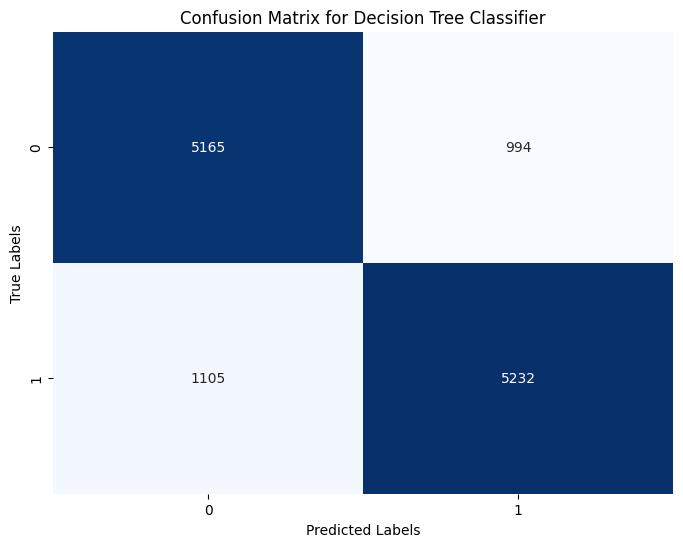

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Calculate the confusion matrix
cm = confusion_matrix(y_test, pred_dt)

#Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Decision Tree Classifier")
plt.show()

**3. Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
RFC = RandomForestClassifier(random_state=0)
RFC.fit(xv_train_np, y_train)

RandomForestClassifier(random_state=0)

In [ ]:
pred_rfc = RFC.predict(xv_test_np)

In [ ]:
RFC.score(xv_test_np, y_test)

0.8781209987195903

In [ ]:
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

          CG       0.85      0.91      0.88      6159
          OG       0.91      0.84      0.88      6337

    accuracy                           0.88     12496
   macro avg       0.88      0.88      0.88     12496
weighted avg       0.88      0.88      0.88     12496



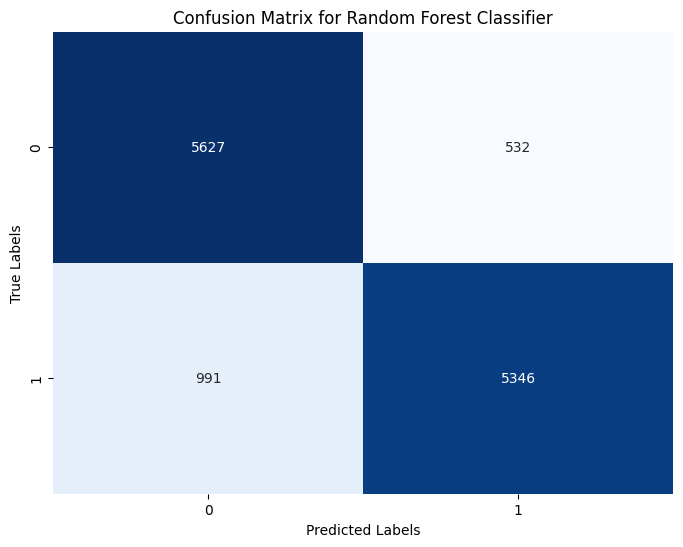

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Calculate the confusion matrix
cm = confusion_matrix(y_test, pred_rfc)

#Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

**4. Support Vector Machine**

In [ ]:
from sklearn.svm import SVC

In [ ]:
SVM = SVC(kernel='linear', random_state=0)
SVM.fit(xv_train_np, y_train)

SVC(kernel='linear', random_state=0)

In [ ]:
pred_svm = SVM.predict(xv_test_np)

In [ ]:
SVM.score(xv_test_np, y_test)

0.8790813060179258

In [ ]:
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

          CG       0.90      0.85      0.87      6159
          OG       0.86      0.91      0.88      6337

    accuracy                           0.88     12496
   macro avg       0.88      0.88      0.88     12496
weighted avg       0.88      0.88      0.88     12496



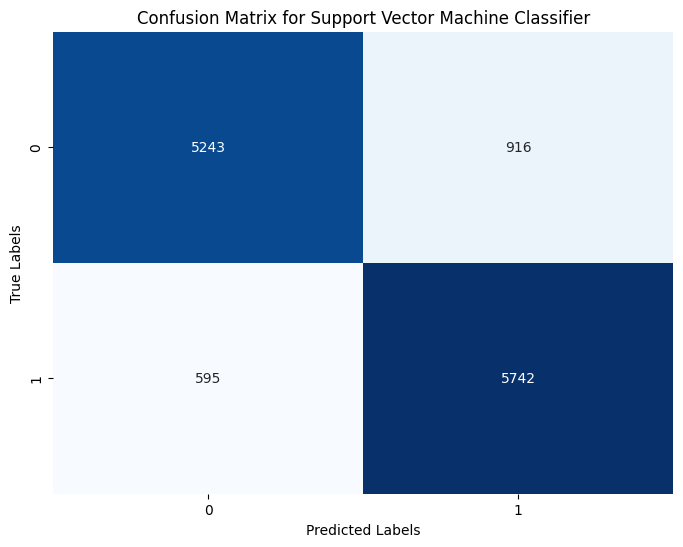

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred_svm)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Support Vector Machine Classifier")
plt.show()

**5. K Nearest Neighbour**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(xv_train_np, y_train)

KNeighborsClassifier()

In [ ]:
pred_knn = KNN.predict(xv_test_np)

In [ ]:
KNN.score(xv_test_np, y_test)

0.4880761843790013

In [ ]:
print(classification_report(y_test, pred_knn))

              precision    recall  f1-score   support

          CG       0.49      0.99      0.66      6159
          OG       0.23      0.00      0.01      6337

    accuracy                           0.49     12496
   macro avg       0.36      0.50      0.33     12496
weighted avg       0.36      0.49      0.33     12496



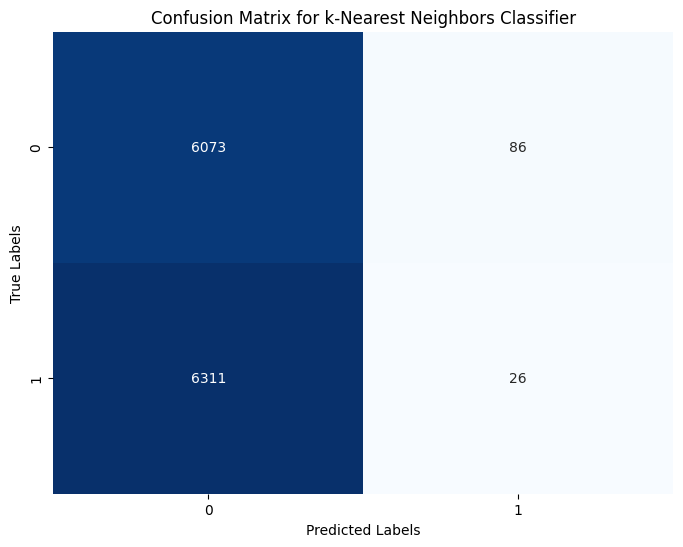

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
#Calculate the confusion matrix
cm = confusion_matrix(y_test, pred_knn)

#Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for k-Nearest Neighbors Classifier")
plt.show()

**6. Naive Bayes Classifier**

In [ ]:
#from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB


In [ ]:
NB = MultinomialNB()
NB.fit(xv_train_np, y_train)
#NB = GaussianNB()
#NB.fit(xv_train_np, y_train)

MultinomialNB()

In [ ]:
pred_nb = NB.predict(xv_test_np)

In [ ]:
NB.score(xv_test_np, y_test)

0.6893405889884763

In [ ]:
print(classification_report(y_test, pred_nb))

              precision    recall  f1-score   support

          CG       0.93      0.40      0.56      6159
          OG       0.62      0.97      0.76      6337

    accuracy                           0.69     12496
   macro avg       0.78      0.69      0.66     12496
weighted avg       0.78      0.69      0.66     12496



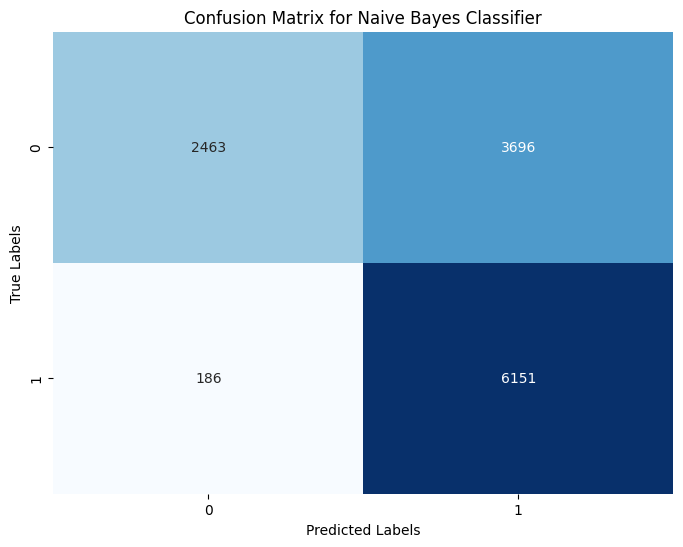

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
#Calculate the confusion matrix
cm = confusion_matrix(y_test, pred_nb)

#Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Naive Bayes Classifier")
plt.show()

**7. XG BOOST**

In [ ]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# Convert string labels to numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Now fit the model using the numeric labels
XG = xgb.XGBClassifier()
XG.fit(xv_train_np, y_train_encoded)  # Use numeric labels


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
pred_xg = XG.predict(xv_test_np)

In [ ]:
y_test_encoded = label_encoder.transform(y_test)


In [ ]:
XG.score(xv_test_np, y_test_encoded)

0.9050096030729834

In [ ]:
print(classification_report(y_test_encoded, pred_xg))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      6159
           1       0.91      0.91      0.91      6337

    accuracy                           0.91     12496
   macro avg       0.90      0.90      0.90     12496
weighted avg       0.91      0.91      0.91     12496



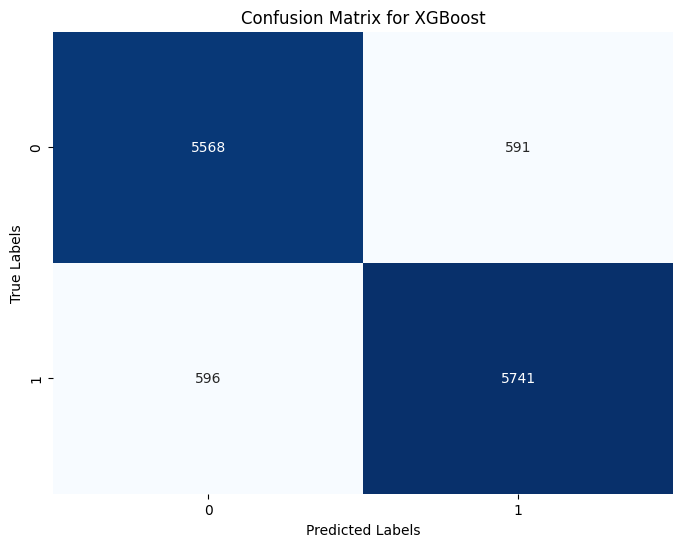

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test_encoded, pred_xg)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for XGBoost")
plt.show()

In [ ]:
Now we will select the best model from all the seven model we have trained

In [ ]:

def evaluate_model(name, y_true, y_pred, results, use_encoded=False):
    pos = 1 if use_encoded else 'OG'
    results[name] = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, pos_label=pos, average='binary'),
        "Recall": recall_score(y_true, y_pred, pos_label=pos, average='binary'),
        "F1 Score": f1_score(y_true, y_pred, pos_label=pos, average='binary')
    }

#Collecting results for all models
results = {}
evaluate_model("Logistic Regression", y_test, pred_LR, results)
evaluate_model("Decision Tree", y_test, pred_dt, results)
evaluate_model("Random Forest", y_test, pred_rfc, results)
evaluate_model("SVM", y_test, pred_svm, results)
evaluate_model("KNN", y_test, pred_knn, results)
evaluate_model("Naive Bayes", y_test, pred_nb, results)
evaluate_model("XGBoost", y_test_encoded, pred_xg, results, use_encoded=True)

# Display results
results_df = pd.DataFrame(results).T
print("Model Comparison:")
print(results_df.sort_values("F1 Score"))

Model Comparison:
                     Accuracy  Precision    Recall  F1 Score
KNN                  0.488076   0.232143  0.004103  0.008063
Naive Bayes          0.689341   0.624657  0.970649  0.760133
Decision Tree        0.832026   0.840347  0.825627  0.832922
Random Forest        0.878121   0.909493  0.843617  0.875317
Logistic Regression  0.872199   0.851319  0.906265  0.877933
SVM                  0.879081   0.862421  0.906107  0.883725
XGBoost              0.905010   0.906665  0.905949  0.906307


Now select the best model

In [ ]:

best_model_name = results_df["F1 Score"].idxmax()
print(f"Best-performing model based on F1 Score: {best_model_name}")

Best-performing model based on F1 Score: XGBoost


We will undestand and anayse the report and results of the best model

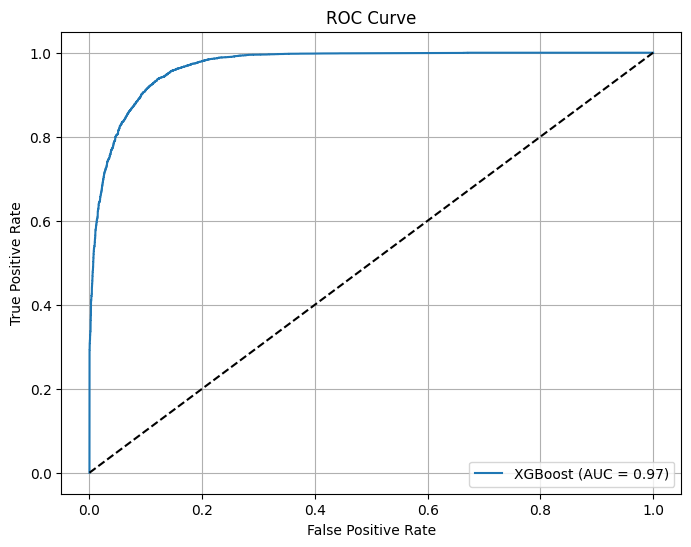

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

#Predict probabilities with XGBoost
if hasattr(XG, "predict_proba"):
    y_prob = XG.predict_proba(xv_test_np)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_encoded, y_prob, pos_label=1)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc_score(y_test_encoded, y_prob):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("ROC Curve cannot be plotted for XGBoost (no predict_proba method).")


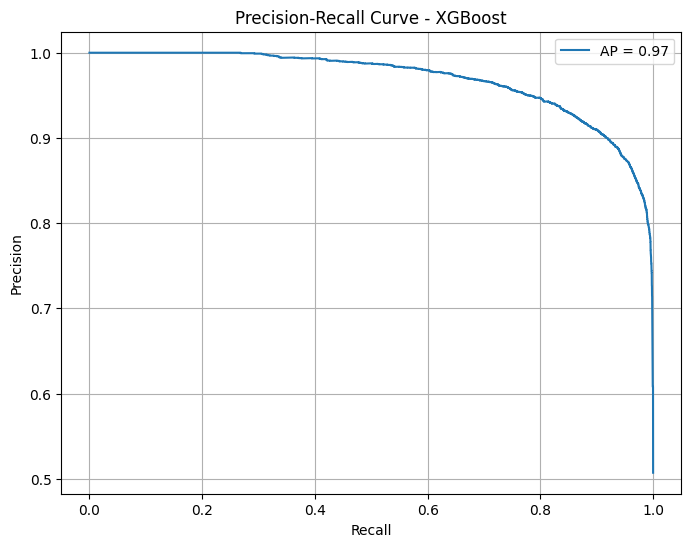

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test_encoded, y_prob)
ap = average_precision_score(y_test_encoded, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP = {ap:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - XGBoost")
plt.legend()
plt.grid(True)
plt.show()


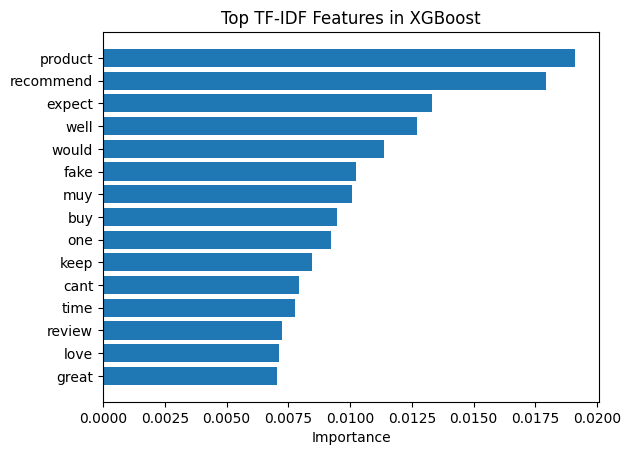

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(x_train)  # original text data

# Get feature importance from XGBoost
importances = XG.feature_importances_
features = vectorizer.get_feature_names_out()

# Combine and sort
top_features = sorted(zip(importances, features), reverse=True)[:15]

# Bar plot
importance_vals, feature_names = zip(*top_features)
plt.barh(feature_names, importance_vals)
plt.xlabel("Importance")
plt.title("Top TF-IDF Features in XGBoost")
plt.gca().invert_yaxis()
plt.show()


XGBoost emerged as the best performing model with an outstanding ROC(Receiver operating characteristic curve)-AUC(Area under the curve) and Average Precision score of 0.97, demonstrating excellent classification ability. It achieved high values across all key metrics Accuracy (90.5%), Precision (90.7%), Recall (90.6%), and F1 Score (90.6%), indicating a well-balanced model. The top influential TF-IDF features like "product", "recommend", and "fake" offer valuable interpretability into what drives predictions.


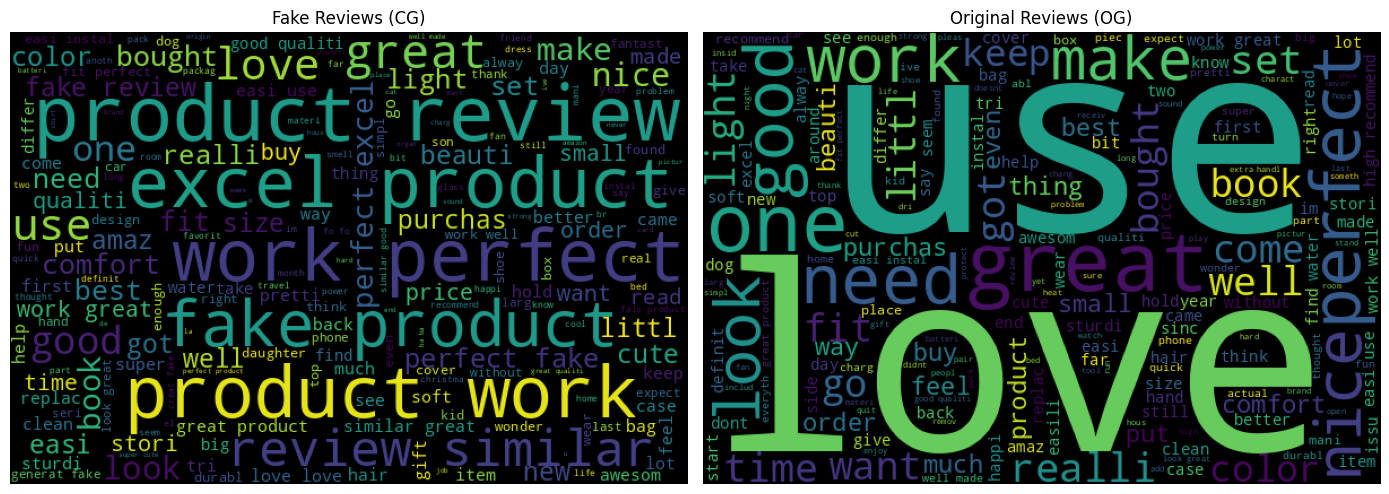

In [ ]:
from wordcloud import WordCloud

fake_text = " ".join(x_train[y_train == 'CG'])
real_text = " ".join(x_train[y_train == 'OG'])

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(WordCloud(width=600, height=400).generate(fake_text))
plt.title("Fake Reviews (CG)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(WordCloud(width=600, height=400).generate(real_text))
plt.title("Original Reviews (OG)")
plt.axis('off')

plt.tight_layout()
plt.show()


Manual Testing (optional)

In [ ]:
# Manual testing function
def manual_test(review):
    review_cleaned = text_cleaning(review)
    vector_input = vectorization.transform([review_cleaned])
    prediction = XG.predict(vector_input)
    result = "Fake Review" if prediction[0] == 1 else "Genuine Review"
    return result



In [ ]:
review = input()

print("Review 1:", manual_test(review))


"This is the best product I have ever used in my life!!! It changed everything overnight. I can't believe how amazing it is. Everyone should buy this RIGHT NOW. I would give it 100 stars if I could!!! Absolutely flawless in every way
Review 1: Fake Review
